In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import flags, app
import numpy as np
import skimage.io as skio
import plotly.express as px
import pandas as pd
from saveo import save_obj
import sys
import torch
import torchvision
from torch.nn import functional as F

from nnutils import test_utils
from nnutils import predictor as pred_util
from utils import image as img_util
import soft_renderer.functional as srf
from matplotlib import pyplot as plt
from nnutils import geom_utils

import io
from PIL import Image


In [2]:
flags.DEFINE_string('img_path', 'misc/demo_data/img4.jpg', 'Image to run')
flags.DEFINE_integer('img_size', 256, 'image size the network was trained on.')
flags.DEFINE_string('f','','')

In [3]:
def preprocess_image(img_path, img_size=256):
    img = skio.imread(img_path) / 255.

    # Scale the max image size to be img_size
    scale_factor = float(img_size) / np.max(img.shape[:2])
    img, _ = img_util.resize_img(img, scale_factor)

    # Crop img_size x img_size from the center
    center = np.round(np.array(img.shape[:2]) / 2).astype(int)
    # img center in (x, y)
    center = center[::-1]
    bbox = np.hstack([center - img_size / 2., center + img_size / 2.])

    img = img_util.crop(img, bbox, bgval=1.)

    # Transpose the image to 3xHxW
    img = np.transpose(img, (2, 0, 1))

    return img

In [4]:
def visualize(img, outputs, renderer):
    vert = outputs['verts'][0]
    cam = outputs['cam_pred'][0]
    texture = outputs['texture'][0]
    faces = outputs['faces'][0]
    shape_pred = renderer(vert, cam)
    img_pred = renderer(vert, cam, texture=texture)
    #renderer.saveMesh(vert, texture)
    
    vertex_seg_map = torch.argmax(outputs['vertex_seg_map'][0], dim=1).unsqueeze(1).type(torch.FloatTensor)
    x = torch.cat([vert.cpu(), vertex_seg_map], dim=1)
    print(outputs['vertex_seg_map'][0].max(1)[0].sum()) 
    df = x.numpy()
    df = pd.DataFrame(df)

    fig = px.scatter_3d(df, x=0, y=1, z=2, color=3)
    fig.write_html("./file.html")
    print("file.html written")

    tex_seg = vertex_seg_map.repeat(1, 3)
    for i in range(642):
        if(tex_seg[i][0].item() == 0.0):
            tex_seg[i] = torch.tensor([0.0, 0.0, 1.])
        elif(tex_seg[i][0].item() == 1.0):
            tex_seg[i] = torch.tensor([0.0, 1.0, 0.0])
        elif(tex_seg[i][0].item() == 2.0):
            tex_seg[i] = torch.tensor([0.0, 1.0, 1.0])
        elif(tex_seg[i][0].item() == 3.0):
            tex_seg[i] = torch.tensor([1., 0., 0.])
        elif(tex_seg[i][0].item() == 4.0):
            tex_seg[i] = torch.tensor([1., 0., 1.])
        elif(tex_seg[i][0].item() == 5.0):
            tex_seg[i] = torch.tensor([1., 1., 0.])
        elif(tex_seg[i][0].item() == 6.0):
            tex_seg[i] = torch.tensor([1., 0.5, 0.5])
        elif(tex_seg[i][0].item() == 7.0):
            tex_seg[i] = torch.tensor([0.5, 1, 1])



    save_obj("demo_seg.obj", vert, outputs['faces'][0], tex_seg.contiguous(), texture_type='vertex')
    print("seg_obj file written")

    # Different viewpoints.
    vp1 = renderer.diff_vp(
        vert, cam, angle=30, axis=[0, 1, 0], texture=texture, extra_elev=True)
    vp2 = renderer.diff_vp(
        vert, cam, angle=60, axis=[0, 1, 0], texture=texture, extra_elev=True)
    vp3 = renderer.diff_vp(
        vert, cam, angle=90, axis=[0, 1, 0], texture=texture)

    img = np.transpose(img, (1, 2, 0))
    import matplotlib.pyplot as plt
    plt.ion()
    plt.figure(1)
    plt.clf()
    plt.subplot(231)
    plt.imshow(img)
    plt.title('input')
    plt.axis('off')
    plt.subplot(232)
    plt.imshow(shape_pred)
    plt.title('pred mesh')
    plt.axis('off')
    plt.subplot(233)
    plt.imshow(img_pred)
    plt.title('pred mesh w/texture')
    plt.axis('off')
    plt.subplot(234)
    plt.imshow(vp1)
    plt.title('different viewpoints')
    plt.axis('off')
    plt.subplot(235)
    plt.imshow(vp2)
    plt.axis('off')
    plt.subplot(236)
    plt.imshow(vp3)
    plt.axis('off')
    plt.draw()
    plt.show()
    print('saving file to demo_image.png')
    plt.savefig('demo_image.png')

In [23]:
opts = flags.FLAGS
sys.argv = ['--name', '10_resfeatupsampletrans_bird_net_VS_partbasis_sc_nokp_transcam_ucmr_like_probs_csmtemp//',\
            '--num_train_epoch', '50']
opts(sys.argv)
opts.name = sys.argv[1]

In [33]:
opts.img_path = 'misc/demo_data/img3.jpg'
img = preprocess_image(opts.img_path, img_size=opts.img_size)
img = img[:, :, ::-1].copy()
batch = {'img': torch.Tensor(np.expand_dims(img, 0)), 'mask': torch.Tensor(np.expand_dims(img, 0)).mean(1)}
opts.batch_size = 1
predictor = pred_util.MeshPredictor(opts)

Setting up model..
loading /home/vikrant/CMR_expts/CMR_bkup/cmr_softras_amp/nnutils/../misc/cachedir/snapshots/10_resfeatupsampletrans_bird_net_VS_partbasis_sc_nokp_transcam_ucmr_like_probs_csmtemp//pred_net_50.pth..
Setting up Perceptual loss..
Done


In [34]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    predictor.model.encoder.resnet_conv.resnet.layer4[-1].register_forward_hook(
        lambda self, input, output: conv_features.append(output.detach().cpu())
    ),
    predictor.model.code_predictor.cam_predictor.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1].detach().cpu())
    ),
    predictor.model.code_predictor.cam_predictor.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1].detach().cpu())
    ),
]

In [35]:
predictor.set_input(batch)
# propagate through the model
preds, tex = predictor.model(predictor.input_imgs)

inv_normalize = torchvision.transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im = predictor.input_imgs[0].detach().cpu()
im = np.asarray(torchvision.transforms.functional.to_pil_image(inv_normalize(im)))

for hook in hooks:
    hook.remove()

print(conv_features[0].shape, dec_attn_weights[0].shape, enc_attn_weights[0].shape)

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

torch.Size([1, 512, 9, 9]) torch.Size([1, 8, 256]) torch.Size([1, 256, 256])


In [36]:
dec_attn_weights.shape

torch.Size([1, 8, 256])

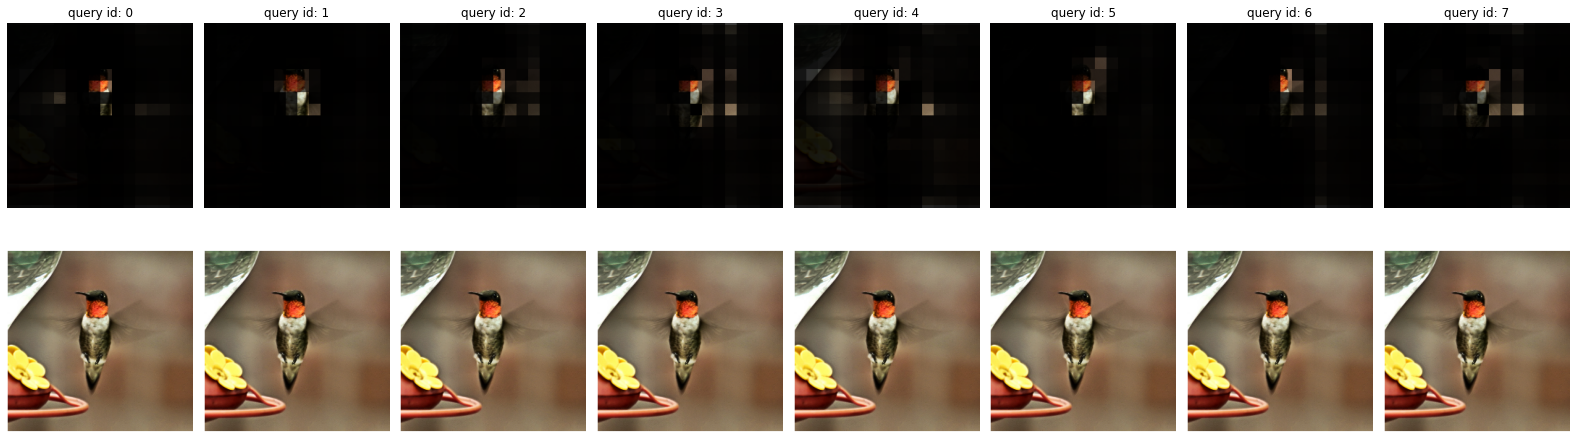

In [37]:
# get the feature map shape
h, w = 16, 16#conv_features.shape[-2:]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

fig, axs = plt.subplots(ncols=8, nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i in zip(range(8), axs.T):
    ax = ax_i[0]
    attn = dec_attn_weights[0, idx]#.view(h, w)
    attn = attn.view(1, 1, h, w)
    attn = F.interpolate(attn.view(1,1,h,w), im.shape[:2], mode='nearest')[0,0]
    attn = (attn - attn.min()) / (attn.max()-attn.min())
    attn = (attn.view(*im.shape[:2], 1)).numpy()
    ax.imshow((attn*im).astype(np.uint8))
    ax.axis('off')
    ax.set_title(f'query id: {idx}')
    ax = ax_i[1]
    ax.imshow(im)
    
    ax.axis('off')
fig.tight_layout()

tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.0000)


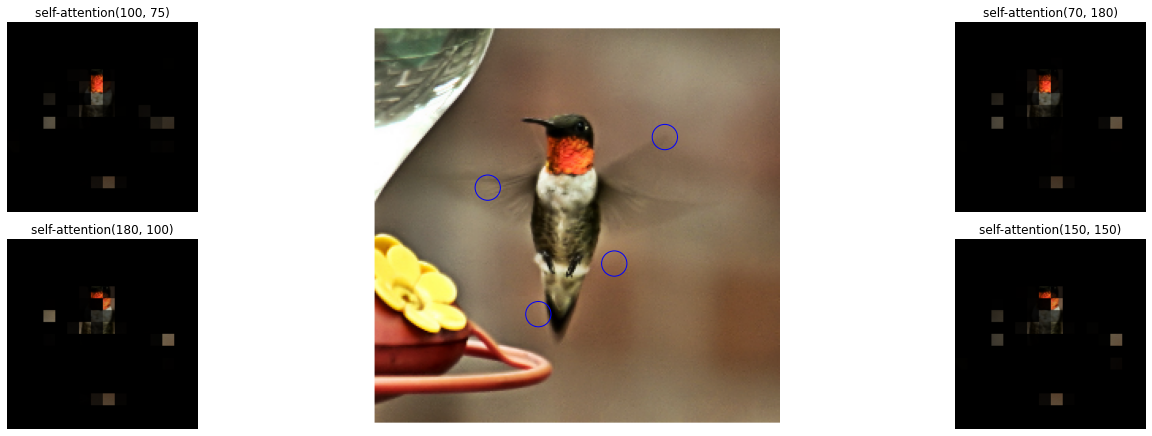

In [38]:
shape = (h, w)#conv_features.shape[-2:]
sattn = enc_attn_weights[0].reshape(shape + shape).detach().cpu()

# downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
fact = 256 // 16

# let's select 4 reference points for visualization
idxs = [(100, 75), (180, 100), (70, 180), (150, 150)]

# here we create the canvas
fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
# and we add one plot per reference point
gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# for each one of the reference points, let's plot the self-attention
# for that point


for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    attn = sattn[idx[0], idx[1]]
    print(attn.sum())
    attn = F.interpolate(attn.view(1,1,h,w), im.shape[:2], mode='nearest')[0,0]
    #attn = F.softmax(attn.view(-1), dim=0)
    attn = (attn - attn.min()) / (attn.max()-attn.min())
    attn = (attn.view(*im.shape[:2], 1)).numpy()
    ax.imshow((attn*im).astype(np.uint8), cmap='cividis', interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')

# and now let's add the central image, with the reference points as red circles
fcenter_ax = fig.add_subplot(gs[:, 1:-1])


fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.shape[0] / img.shape[1]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='b', fill=False))
    fcenter_ax.axis('off')

In [32]:
''''idxs = [(i*fact, j*fact) for i in range(h) for j in range(w)]


# for each one of the reference points, let's plot the self-attention
# for that point

frames = []
for idx_o in idxs:
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(22, 7))
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    x = ((idx_o[1] // fact) + 0.5) * fact
    y = ((idx_o[0] // fact) + 0.5) * fact
    attn = sattn[idx[0], idx[1]]
    attn = F.interpolate(attn.view(1,1,h,w), im.shape[:2], mode='nearest')[0,0]
    #attn = F.softmax(attn.view(-1), dim=0)
    attn = (attn - attn.min()) / (attn.max()-attn.min())
    attn = (attn.view(*im.shape[:2], 1)).numpy()
    axs[0].imshow((attn*im).astype(np.uint8), cmap='cividis', interpolation='bilinear')
    axs[0].add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='b', fill=False))
    axs[0].axis('off')
    axs[0].set_title(f'self-attention{idx_o}')
    
    axs[1].imshow(im)
    scale = im.shape[0] / img.shape[1]
    axs[1].add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='b', fill=False))
    axs[1].axis('off')
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    frames.append(Image.open(buf).copy())
    buf.close()
    plt.close()
    

''''

SyntaxError: EOL while scanning string literal (<ipython-input-32-70aaf113ae40>, line 36)

In [ ]:
'''import cv2

videodims = (200,100)
fourcc = cv2.VideoWriter_fourcc(*'avc1')    
video = cv2.VideoWriter("selfattentions.mp4",fourcc, 60,videodims)
#draw stuff that goes on every frame here
for frame in frames:
    imtemp = frame.copy()
    # draw frame specific stuff here.
    video.write(cv2.cvtColor(np.array(imtemp), cv2.COLOR_RGB2BGR))
video.release()
frames[0].save('selfattentions.gif', save_all=True, append_images=frames[1:], optimize=False, duration=400, loop=0)'''

In [41]:
predictor.model.code_predictor.vertex_part_predictor.vert2part[0]

tensor([[0.8793, 0.8793, 0.8794,  ..., 0.8793, 0.8793, 0.8793],
        [0.8795, 0.8795, 0.8795,  ..., 0.8795, 0.8795, 0.8795],
        [0.8794, 0.8794, 0.8794,  ..., 0.8794, 0.8794, 0.8794],
        ...,
        [0.8787, 0.8787, 0.8787,  ..., 0.8787, 0.8787, 0.8787],
        [0.8787, 0.8787, 0.8787,  ..., 0.8787, 0.8787, 0.8787],
        [0.8787, 0.8787, 0.8787,  ..., 0.8787, 0.8787, 0.8787]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [19]:
preds['cam_hypotheses']


tensor([[[ 1.8817,  0.2384,  0.1499,  0.8127,  0.5186,  0.0243, -0.2644],
         [ 1.5933,  0.1329,  0.1623,  0.7328,  0.5048,  0.4182, -0.1827],
         [ 1.4710,  0.1190,  0.1479,  0.4638,  0.3274,  0.7433, -0.3539],
         [ 1.7809,  0.2145,  0.1715,  0.0999,  0.2767,  0.8147, -0.4998],
         [ 1.7845,  0.2315,  0.1533, -0.2898, -0.0569,  0.4873, -0.8219],
         [ 1.5747,  0.1557,  0.1310,  0.0038, -0.8191,  0.5713, -0.0542],
         [ 1.4965,  0.1282,  0.1501, -0.3870, -0.7719,  0.2877, -0.4146],
         [ 1.8850,  0.2189,  0.1890, -0.5755, -0.7865,  0.2116, -0.0768]]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [76]:
cam_pose = preds['cam_hypotheses']
cam_right_hat = cam_pose * torch.FloatTensor([1, -1, 1, 1, 1, -1, -1]).view(1, 1, -1).cuda()

In [20]:
pred_codes, textures = predictor.model.forward(predictor.input_imgs)

delta_v = pred_codes['shape_pred']
#self.cam_pred = pred_codes['cam']

vertex_part_pred = pred_codes['vertex_part_pred']
cam_pred = pred_codes['cam_hypotheses']

del_v = predictor.model.symmetrize(delta_v)
vertex_seg_map = torch.cat([vertex_part_pred, vertex_part_pred[:, -predictor.model.num_sym:]], 1)

# Deform mean shape:
mean_shape = predictor.model.get_mean_shape()

pred_v = mean_shape + del_v

textures = geom_utils.sample_textures(textures, predictor.imgs)

In [21]:
renderer = predictor.vis_rend
renderer.set_light_dir([0, 1, -1], 0.4)

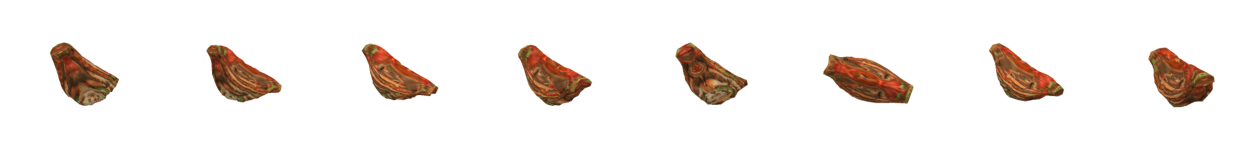

In [22]:
fig, axs = plt.subplots(ncols=8, nrows=1, figsize=(22, 7))
#texture = textures[0].view(textures.shape[1], )
for ax, cam in zip(axs, preds['cam_hypotheses'][0]):
    img_pred = renderer(pred_v, cam, texture=textures[0])
    ax.imshow(img_pred)
    ax.axis('off')

In [75]:
cam_right = torch.Tensor([[[ 1.4819, -0.0915,  0.1428,  0.4727,  0.8123,  0.3364,  0.0584],
         [ 1.3876, -0.0449,  0.1618,  0.4746,  0.8124,  0.2539, -0.2243],
         [ 1.2878, -0.0210,  0.1453,  0.2871,  0.4064,  0.4002, -0.7696],
         [ 1.4822, -0.0586,  0.1487,  0.2515,  0.0969,  0.5015, -0.8222],
         [ 1.4551, -0.1009,  0.1510,  0.0297, -0.3327,  0.8177, -0.4690],
         [ 1.4684, -0.0635,  0.1608,  0.0039, -0.4611,  0.8833, -0.0858],
         [ 1.3008, -0.0426,  0.1514, -0.7618, -0.4243,  0.3940, -0.2912],
         [ 1.4917, -0.0684,  0.1561, -0.8213, -0.5126,  0.0872, -0.2355]]]).cuda()

In [78]:
torch.abs(cam_right - cam_right_hat)

tensor([[[0.0600, 0.0860, 0.0599, 0.3624, 0.3360, 0.3891, 0.2115],
         [0.1616, 0.0984, 0.0533, 0.2677, 0.3571, 0.6824, 0.4656],
         [0.1308, 0.0719, 0.0511, 0.1648, 0.0641, 1.1538, 1.1024],
         [0.1434, 0.0530, 0.0431, 0.1531, 0.1684, 1.3312, 1.3035],
         [0.0579, 0.0864, 0.0729, 0.3206, 0.2712, 1.2737, 1.3080],
         [0.0953, 0.1819, 0.1658, 0.0044, 0.4170, 1.3618, 0.1032],
         [0.1307, 0.0987, 0.0604, 0.4172, 0.3459, 0.7158, 0.7211],
         [0.0713, 0.0712, 0.0428, 0.2836, 0.2961, 0.3104, 0.3214]]],
       device='cuda:0', grad_fn=<AbsBackward>)

In [100]:
vertex_part_pred = torch.cat([preds['vertex_part_pred'], preds['vertex_part_pred'][:, -predictor.model.num_sym:]], 1)
vertex_seg_map = vertex_part_pred.argmax(-1, keepdims=True)[0]
vertex_seg_map.shape

torch.Size([729, 1])

In [101]:
tex_seg = vertex_seg_map.repeat(1, 3)
for i in range(tex_seg.shape[0]):
    if(tex_seg[i][0].item() == 0.0):
        tex_seg[i] = torch.tensor([0.0, 0.0, 1.])
    elif(tex_seg[i][0].item() == 1.0):
        tex_seg[i] = torch.tensor([0.0, 1.0, 0.0])
    elif(tex_seg[i][0].item() == 2.0):
        tex_seg[i] = torch.tensor([0.0, 1.0, 1.0])
    elif(tex_seg[i][0].item() == 3.0):
        tex_seg[i] = torch.tensor([1., 0., 0.])
    elif(tex_seg[i][0].item() == 4.0):
        tex_seg[i] = torch.tensor([1., 0., 1.])
    elif(tex_seg[i][0].item() == 5.0):
        tex_seg[i] = torch.tensor([1., 1., 0.])
    elif(tex_seg[i][0].item() == 6.0):
        tex_seg[i] = torch.tensor([1., 0.5, 0.5])
    elif(tex_seg[i][0].item() == 7.0):
        tex_seg[i] = torch.tensor([0.5, 1, 1])

In [106]:
save_obj("demo_seg.obj", pred_v[0], predictor.model.faces, tex_seg.contiguous(), texture_type='vertex')


In [105]:
predictor.model.faces.shape

torch.Size([1454, 3])

In [108]:
(vertex_seg_map==0).sum()

tensor(51, device='cuda:0')